# 3D CNN Feature Extraction and kNN Testing

In [36]:
import os
import pickle
import h5py
import json
import numpy as np
import seaborn as sn
import pandas as pd
import importlib
# import imageio
# from skimage import transform
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import glob
import subprocess

# custome modules
import cnn3d_similarity_inference
import knn_cnn_features
importlib.reload(knn_cnn_features)

<module 'knn_cnn_features' from '/Users/ryanbae/Dropbox/uw_data_science/capstone/VideoSimilarity/knn_cnn_features.py'>

## Accuracy Test

In [16]:
# load feature vectors and video labels
feature_vectors = cnn3d_similarity_inference.load_feature_vectors('feature_vectors_cnn3d_ucf101', './cnn3d_features')
video_labels = cnn3d_similarity_inference.load_video_labels('video_labels_cnn3d_ucf101', './cnn3d_features')
video_labels = np.array([fl.decode() for fl in video_labels])

loading feature vectors...
loading video labels...


In [46]:
# get video labels
ucf_classes = [vid.split('/')[-1].split('_')[1] for vid in video_labels]
ucf_classes = sorted(list(set(ucf_classes)))
print("There are",len(ucf_classes),"classes in UCF dataset")

There are 101 classes in UCF dataset


In [17]:
# check loaded feature and label sizes
print(feature_vectors.shape)
print(len(video_labels))

(13320, 512)
13320


In [18]:
%timeit feature_indices = knn_cnn_features.run_knn_features(feature_vectors=feature_vectors, k=3, gpu=False)

555 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
# perform kNN search for every video in the UCF-101 dataset
feature_indices = knn_cnn_features.run_knn_features(feature_vectors=feature_vectors, k=3, gpu=False)

In [20]:
# get similar video labels
similar_videos = video_labels[feature_indices]

In [21]:
def get_cls_accuracy(similar_videos, feature_labels, k=3):
    accuracy = 0
    for i, sim_vids in enumerate(similar_videos):
        true_label = feature_labels[i].split('_')[1]
        for sim_vid in sim_vids:
            pred_label = sim_vid.split('_')[1]
            accuracy += np.sum(pred_label==true_label)/k
    return accuracy/len(feature_labels)

In [22]:
accuracy = get_cls_accuracy(similar_videos, video_labels)
print("Accuracy:", round(accuracy, 3))

Accuracy: 0.815


## Accuracy Test with Test/Train Split

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, video_labels, \
                                        test_size=0.3, random_state=42)

In [30]:
%timeit feature_indices = knn_cnn_features.run_knn_features(X_train, test_vectors=X_test, k=3, gpu=False)

383 ms ± 73.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
feature_indices = knn_cnn_features.run_knn_features(X_train, test_vectors=X_test, k=3, gpu=False)

In [32]:
similar_videos = y_train[feature_indices]

In [33]:
print("Accuracy:", round(get_cls_accuracy(similar_videos, y_test), 3))

Accuracy: 0.607


## Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix

In [37]:
similar_videos_flat = [item.split('_')[1] for sublist in similar_videos for item in sublist]
y_test_flat = [item.split('_')[1] for item in y_test for i in range(3)]

In [38]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_flat, similar_videos_flat)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
# np.set_printoptions(precision=2)

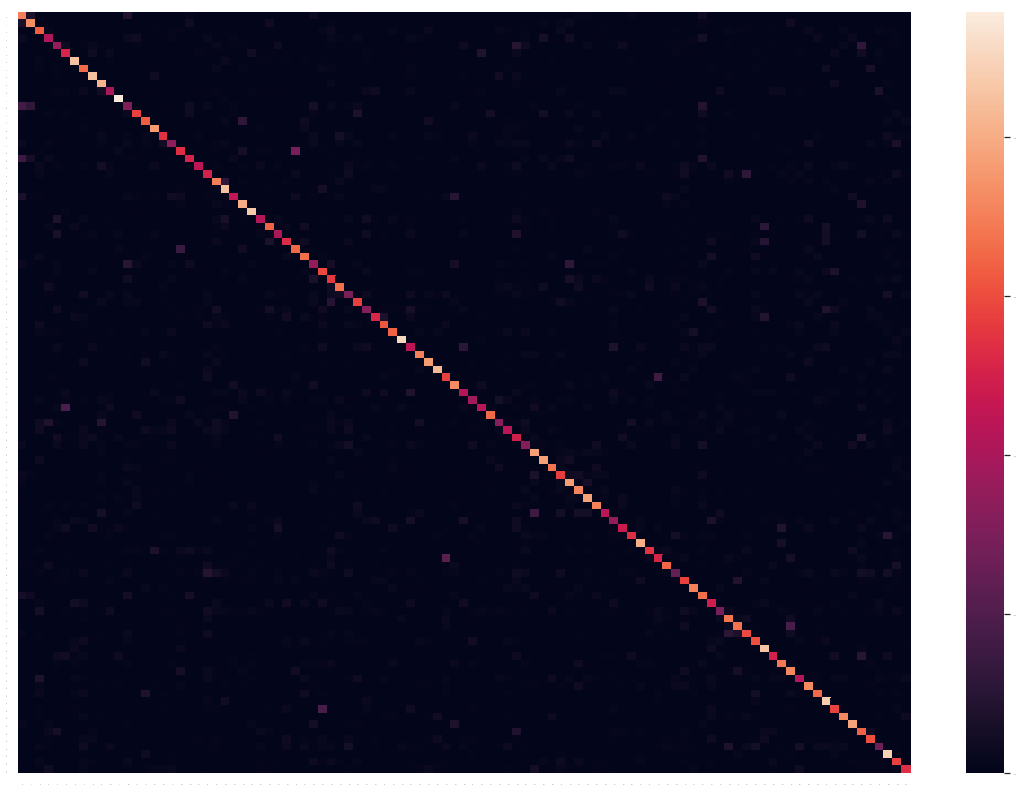

In [39]:
df_cm = pd.DataFrame(cnf_matrix, range(101),
                  range(101))
plt.figure(figsize = (20,14))
sn.set(font_scale=0.1)#for label size
sn.heatmap(df_cm, annot=False)# font size ,annot_kws={"size": 16}

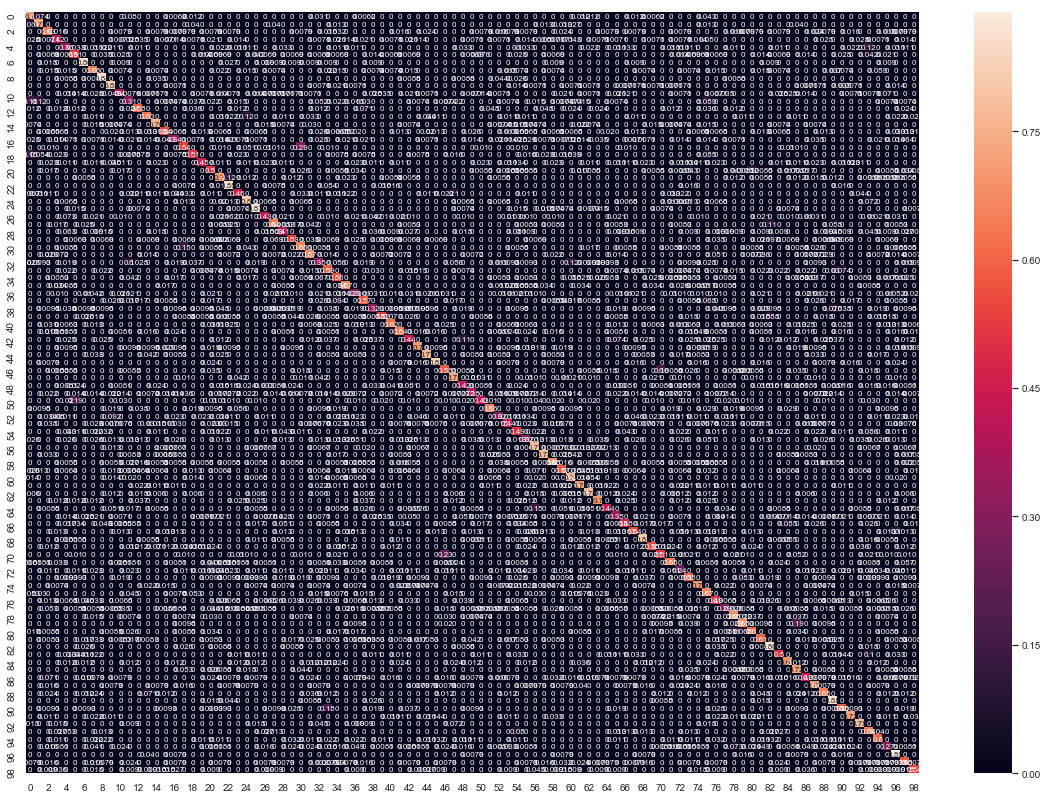

In [40]:
nsa = []
for i in range(101):
    if cnf_matrix[i,i]<0.9:
        nsa.append(i)
cnf_matrix_mini = cnf_matrix[nsa,:][:,nsa]
df_cm = pd.DataFrame(cnf_matrix_mini, range(len(nsa)),
                  range(len(nsa)))
plt.figure(figsize = (20,14))
np.set_printoptions(precision=3)
sn.set(font_scale=0.9)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

In [63]:
notsogood = []
for i, row in enumerate(cnf_matrix):
    for j, colj in enumerate(row):
        if colj > 0.17 and i != j:
            print(cnf_matrix[i,j])
            notsogood.append([i,j])

0.29292929292929293
0.1919191919191919
0.22916666666666666
0.18627450980392157
0.17592592592592593


In [64]:
for nsgi in notsogood:
    print(ucf_classes[nsgi[1]], "->", ucf_classes[nsgi[0]])

FrontCrawl -> BreastStroke
BandMarching -> MilitaryParade
Kayaking -> Rafting
Surfing -> Skijet
HammerThrow -> ThrowDiscus
